In [19]:
# To Do
# ewa
# X y index alignment fn for pipeline
# xgboost?
# from sklearn import svm

In [20]:
Author = 'Conrad'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import time
import pytz
local_timezone = 'America/Los_Angeles'
from time import gmtime, strftime

from scipy import stats
import numpy as np
import pandas as pd
#from pandas.plotting import scatter_matrix
import xarray as xr
from pandas import Series
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

from sklearn import preprocessing
#from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import Binarizer as binarizer

from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import cluster
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import mixture
                                  
from sklearn.metrics import mean_squared_error as rmse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r_squared
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
                                  
                                  
# import statsmodels 
# from statsmodels.graphics.api import qqplot
# import statsmodels.api as sm
# import statsmodels.tsa.api as ts
# from statsmodels.formula.api import ols
# import statsmodels.regression.linear_model as smlm
# import itertools




#import warnings
#warnings.filterwarnings("ignore")



In [21]:
# SET KEYLINE TIME RELATED PARAMETERS
calendar = {}
calendar['z_score_window'] = 252
calendar['regression_est_window'] = 400
#calendar['tscale'] = ['M','W','D']
calendar['sim_time'] = time.strftime('%x %X')
calendar['trim_pct'] = .01
calendar['ewa_halflife'] = 3

print(calendar['sim_time'])

11/28/23 16:01:55


In [22]:
# FUNCTION FOR TIME-SAFE Z-SCORES
def z_score(df,window = calendar['z_score_window']):
    window = calendar['z_score_window']
    rstd = df.rolling(window=window,min_periods=window).std()
    rmean = df.rolling(window=window,min_periods=window).mean()
    z = (df - rmean) / rstd
    z = z.dropna()
    return z




In [23]:
# FUNCTIONS FOR Re-Basing Returns & computing log returns from a price levels

def rebase_rets(input):
    output = pd.DataFrame(input).set_index(pd.DatetimeIndex(input.index))
    output = output.dropna()
    output = 1+output.cumsum()
    return output

def log_returns(df):
    df = np.log(df)
    df = df - df.shift(1)
    #df.index.name = None
    return df

def pct_returns(df):
    df = df.pct_change()
    return df

def generate_train_predict_calender(df, window_size):
    date_ranges = []
    index = df.index
    num_days = len(index)

    for i in range(0, num_days - window_size):
        #if i + window_size <= len(index):
        train_start_date = index[i]
        train_end_date = index[i + window_size - 1]
        prediction_date = index[i + window_size]
        date_ranges.append([train_start_date, train_end_date, prediction_date])

    return date_ranges


def apply_ewm(X, halflife):
    return X.ewm(halflife=halflife).mean()

In [24]:
# Load Features
spyders = pd.read_csv('SPYDERS.csv')
spyders.Date = pd.DatetimeIndex(spyders['Date'])
spyders.set_index(spyders.Date,inplace=True)
X_level = spyders.drop('Date',axis=1)

In [25]:
# Load Targets
macro_df = pd.read_csv('macro.csv')
macro_df.Date = pd.DatetimeIndex(macro_df['Date'])
macro_df.set_index(['Date'], inplace=True)
y_level = macro_df[['spy']]

In [26]:
# Synch Indexes & Preprocess Features and Targets

df_all = pd.concat([y_level.dropna(),X_level.dropna()], axis=1, join='inner') # sync the X,y indexes
df_all
X_level = df_all.drop(['spy'],axis=1)   # break out features
X_log_returns = log_returns(X_level).shift(1)  # Lagging all features 1 day 
#X_log_returns = pct_returns(X_level).shift(1)  # Lagging all features 1 day 
X = z_score(X_log_returns,calendar['z_score_window']) # preprocess as z-scores

y_level = df_all['spy']  # break out targets
y = log_returns(y_level)  # process as log returns
y = y.loc[X.index]


In [27]:
from sklearn.preprocessing import FunctionTransformer
halflife = 3

# Create a pipeline with FunctionTransformer and RandomForestRegressor
pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])
#pipe.fit_transform(X)

In [28]:
def sim_stats(reg_out,testlabel,author='CG'):
    df = pd.DataFrame()
    df.loc['mean',testlabel] = mean = 252*reg_out.perf.mean()
    df.loc['stdev',testlabel] = std = (np.sqrt(252))*reg_out.perf.std()
    df.loc['sharpe',testlabel] = mean / std
    df.loc['rmse',testlabel] = np.sqrt(rmse(reg_out.predicted,reg_out.actual))
    df.loc['mae',testlabel] = mae(reg_out.predicted,reg_out.actual)
    df.loc['evs',testlabel] = evs(reg_out.predicted,reg_out.actual)
    df.loc['r2',testlabel] = r_squared(reg_out.predicted,reg_out.actual)
    df.loc['benchmark return',testlabel] = bench_ret = 252*reg_out.actual.mean()
    df.loc['benchmark std',testlabel] = bench_std = (np.sqrt(252))*reg_out.actual.std()
    df.loc['benchmark sharpe',testlabel] = bench_ret / bench_std
    df.loc['beg_pred',testlabel] = min(reg_out.actual.index).date()
    df.loc['end_pred',testlabel] = max(reg_out.actual.index).date()
    df.loc['train window',testlabel] = window=calendar['regression_est_window'] 
    df.loc['z_score_window',testlabel] = calendar['z_score_window']
    #df.loc['sim_time @ author',testlabel] =  datetime.now(pytz.timezone(local_timezone)).strftime("%Y-%m-%d %H:%M")
    df.loc['sim_time',testlabel] =  datetime.now(pytz.timezone(local_timezone)).strftime("%x %-I:%-m%p") 
    df.loc['author',testlabel] = author
    return df

In [29]:
# ROLL FORWARD SIMULATOR - 1) TRAIN UP TO T-1, 2) PREDICT AT T, 3) TRADE

def Simulate(X,y,window=calendar['regression_est_window'],pipe_steps={},dims_dict={}):    
    regout = pd.DataFrame(index=y.index)
    
    date_ranges = generate_train_predict_calender(X, window)
    
    pipe = Pipeline(steps=pipe_steps)
    pipe.set_params(**dims_dict)

    for n,dates in enumerate(date_ranges):

        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]

        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]
        
        pipe.fit(fit_X,fit_y)
        #print('pred_date',prediction_date,'features = ',pipe.named_steps['eln'].n_features_in_)
        #regout.loc[prediction_date,'expl_var'] = pipe.named_steps['pca'].explained_variance_ratio_[2]
        #regout.loc[prediction_date,'coeff_1st_dim'] = pipe.named_steps['reg'].coef_[0]
                
        regout.loc[prediction_date,'predicted'] = pipe.predict(pred_X)
            
    # Add actual spy returns
    regout['actual'] = y[regout.predicted.index].dropna()
    print('pds' ,regout.actual.dropna().index)
    regout.loc[regout['predicted'].dropna().index,'random'] = np.random.permutation(regout['predicted'].dropna())
    
    
    # Add trading rule and store performance in 'perf' and 'mtm' columns
    regout['perf'] = np.select([ regout['predicted'] >= 0, regout['predicted'] < 0 ],[ regout['actual'],regout['actual']*-1], default=np.nan)
    regout['mtm'] = (1+regout['perf']).cumprod()-1
    regout['rand_perf'] = np.select([ regout['random'] >= 0, regout['random'] < 0 ],[ regout['actual'],regout['actual']*-1], default=np.nan)
    regout['rand_mtm'] = (1+regout['rand_perf']).cumprod()-1

    return regout.dropna()

In [32]:
y

Date
2001-01-03    0.046917
2001-01-04   -0.010823
2001-01-05   -0.033187
2001-01-08    0.007711
2001-01-09   -0.002644
                ...   
2016-08-01   -0.000829
2016-08-02   -0.006428
2016-08-03    0.002918
2016-08-04    0.001063
2016-08-05    0.008146
Name: spy, Length: 3922, dtype: float64

In [30]:
# Simulate Dim Reduction 

## Dim Reduction
pca = PCA()
clust = cluster.FeatureAgglomeration(n_clusters=4)
kbest = SelectKBest(chi2, k=20)

## Estimators
ols = LinearRegression()
eln = ElasticNet()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=.5)

Results_xr = xr.Dataset()
Results_df = pd.DataFrame()

max_sweep_n = 9
sweep_n = [n+1 for n in range(max_sweep_n)]
pca_tags = sweep_tags = ['pca'+str(n)+'reg' for n in sweep_n]

for n, test_param in enumerate(sweep_n):
    pipe_steps=[('pca', PCA()), ('ols', LinearRegression())]
    dims_dict = {'pca__n_components':test_param,'ols__fit_intercept':True}
    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])
    

pds DatetimeIndex(['2001-01-03', '2001-01-04', '2001-01-05', '2001-01-08',
               '2001-01-09', '2001-01-10', '2001-01-11', '2001-01-12',
               '2001-01-16', '2001-01-17',
               ...
               '2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28',
               '2016-07-29', '2016-08-01', '2016-08-02', '2016-08-03',
               '2016-08-04', '2016-08-05'],
              dtype='datetime64[ns]', name='Date', length=3922, freq=None)
pds DatetimeIndex(['2001-01-03', '2001-01-04', '2001-01-05', '2001-01-08',
               '2001-01-09', '2001-01-10', '2001-01-11', '2001-01-12',
               '2001-01-16', '2001-01-17',
               ...
               '2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28',
               '2016-07-29', '2016-08-01', '2016-08-02', '2016-08-03',
               '2016-08-04', '2016-08-05'],
              dtype='datetime64[ns]', name='Date', length=3922, freq=None)
pds DatetimeIndex(['2001-01-03', '2001-01-04', '2001-01-05', '

KeyboardInterrupt: 

In [14]:
# Simulate Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression
kbest = SelectKBest(chi2, k=20)

max_sweep_n = 2
sweep_n = [n+1 for n in range(max_sweep_n)]
kbest_tags = sweep_tags = ['kbest'+str(n)+'reg' for n in sweep_n]

Results_kbest_xr = xr.Dataset()
Summary_list = []

for n, test_param in enumerate(sweep_n):
    pipe_steps=[('kb', SelectKBest(k=test_param,score_func=f_regression)), ('ols', LinearRegression(fit_intercept=True))]
    dims_dict = {}

    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])
 

In [18]:
Results_df

,pca1reg,pca2reg,pca3reg,pca4reg,pca5reg,pca6reg,pca7reg,pca8reg,pca9reg,kbest1reg,kbest2reg
mean,0.097645,0.111013,0.072561,0.056946,0.069488,0.079951,0.0695,0.006804,0.06108,0.105567,0.087154
stdev,0.193079,0.193051,0.193123,0.193144,0.193128,0.193112,0.193128,0.193177,0.193139,0.193063,0.193099
sharpe,0.505726,0.575043,0.375723,0.294835,0.359805,0.414016,0.359864,0.035219,0.316247,0.5468,0.451345
rmse,0.012185,0.01216,0.012188,0.012211,0.012203,0.012235,0.01225,0.012274,0.012274,0.012158,0.01218
mae,0.007983,0.007981,0.007999,0.008023,0.008043,0.008063,0.008081,0.008106,0.008108,0.007985,0.008007
evs,-127.904028,-60.709349,-54.240204,-47.424833,-38.495448,-35.271583,-31.549262,-29.328765,-27.056533,-53.967031,-49.96056
r2,-127.910602,-60.712133,-54.242792,-47.427008,-38.49759,-35.273309,-31.550987,-29.330491,-27.057983,-53.969602,-49.963052
benchmark return,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197,0.082197
benchmark std,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108,0.193108
benchmark sharpe,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651,0.425651


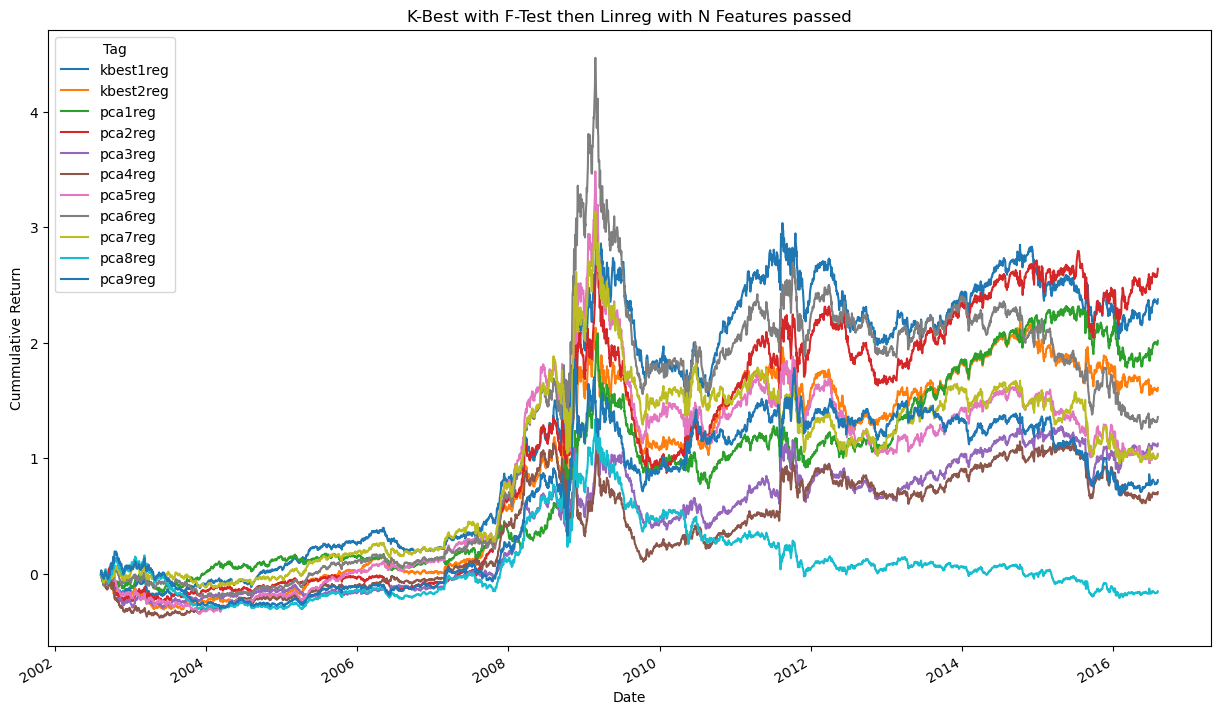

In [17]:

Results_xr['mtm'].plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_xr['mtm'].sel(Tag=pca_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_df.T['mean'].plot()


In [ ]:
# estimators = [
#     ("OLS", LinearRegression()),
#     ("Theil-Sen", TheilSenRegressor(random_state=42)),
#     ("RANSAC", RANSACRegressor(random_state=42)),
# ]

ols =  LinearRegression(fit_intercept=True)
ridge = Ridge(alpha=.9,fit_intercept=True)
eln = ElasticNet(random_state=0,alpha=.5,l1_ratio=.5,fit_intercept=True,selection='random')

learners = [ols, ridge, eln]
learner_tags = sweep_tags = [str(x) for x in learners]


for n, learner_tested in enumerate(learners):
    pipe_steps=[('pca', PCA(n_components=2)), (learner_tags[n], learners[n])]
    dims_dict = {}

    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])





In [ ]:
Results_xr['mtm'].sel(Tag=learner_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])


max_sweep_n = 5
sweep_n = [n+1 for n in range(1,max_sweep_n)]
kbest_tags = sweep_tags = ['ewm_'+str(n)+'_reg' for n in sweep_n]

#Results_kbest_xr = xr.Dataset()
#Summary_list = []

for n, test_param in enumerate(sweep_n):
    pipe_steps=[('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': test_param})), ('ols', LinearRegression(fit_intercept=True))]
    dims_dict = {}

    regout_df = Simulate(X,y,window=calendar['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])

In [ ]:
Results_xr['mtm'].sel(Tag=kbest_tags).plot.line(x='Date')
plt.title('K-Best with F-Test then Linreg with N Features passed')
plt.ylabel('Cummulative Return')
plt.show()

In [ ]:
Results_df

In [ ]:
# Function to generate random guess bets with 50% up and 50% down
# Returns a,b : a = regression metrics and b = df of out of sample predictions and targets
def random_bets(max_trials=50):
    rand_results=pd.DataFrame()
    rand_grets=pd.DataFrame()
    for t in range(max_trials):
        tags = 'Ramdom ' + str(t)
        X_bench = pd.DataFrame(np.random.choice([1,-1],size=(len(y.index),1)),columns=['Random'],index=y.index)
        rand_out = rreg(X_bench,y,drop_pred_indercept = False)
        rand_trade_out, rand_oos  = trule(rand_out)
        col_rand_results = regmetrics(rand_out,rand_trade_out,'tags')
        
        rand_results[tags] = col_rand_results['tags']
        rand_grets[tags] = rand_oos['strat_ret']
    return rand_results, rand_grets

In [ ]:
# DATA ANALYSIS - VIEW CORRELATION PROPERTIES BETWEEN SPY AND EACH OF ITS SECTOR COMPONENTS
import seaborn as sns
corr = dl.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu')
ax.get_figure().savefig('correl.png')



In [ ]:
import numpy as np
from sklearn import datasets, cluster
digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
agglo = cluster.FeatureAgglomeration(n_clusters=32)
agglo.fit(X)
X_reduced = agglo.transform(X)
print(X_reduced.shape,X.shape)

In [ ]:
#
#  this is the end of testing - the rest are summary / diagnostics, some of which run very slowly
#

In [ ]:
# COMPUTE N RANDOM STRATEGIES (50% up 50% down guess) AND GRAPH PERFOMANCE
a , Rand_Rets = random_bets(100)
c = rebase_rets(Rand_Rets)
print("Average Return when guessing = ", a.T['return'].mean())
c.plot()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [ ]:
# Classify the results into Up vs Down and then compute Confusion Matrix and Classification Report
#binarizer.__init__(threshold=0.0,copy=True)  # get an instance of the class
binarizer = preprocessing.Binarizer().fit(X)
Xbin = pd.DataFrame(binarizer.fit_transform(gretsX),index=gretsX.index)
ybin = pd.DataFrame(y,index=gretsX.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
class_names = ['up','down']
for col in Xbin.columns:
    print(col)
    print(classification_report(ybin,Xbin[col],target_names=class_names))
    #print(col)
    #test = Xbin[col]
    #print(test.tail)
    cfm = confusion_matrix(ybin,Xbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')
    
 

In [ ]:
# Classify the Random results into Up vs Down and then compute Confusion Matrix and Classification Report
a , random_rets = random_bets(5)

Xrandbin = pd.DataFrame(binarizer.transform(random_rets),index=random_rets.index)
ybin = pd.DataFrame(y,index=random_rets.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
for col in Xrandbin.columns:
    print(classification_report(ybin,Xrandbin[col],target_names=class_names))
    cfm = confusion_matrix(ybin,Xrandbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')


In [ ]:
#RESULTS - GRAPH RECOMMENDED MODEL AGAINST NON-PCA BENCHMARK, SPY, AND NON-SCORED FEATURES
final_graph = rebase_rets(pd.concat([gretsX['DL_PCA 2'], gretsXz['DLZ_PCA 2'],Regg_Rets['Non-PCA_Benchmark'],spy], axis=1, join='inner').dropna())
final_graph.plot()
figg = plt.gcf()
figg.savefig('final_graph.png')

In [ ]:
final_table = pd.concat([resultsX['DL_PCA 2'], resultsXz['DLZ_PCA 2']], axis=1, join='inner').dropna()

final_table

In [ ]:
from sklearn.linear_model import *

# Get all names in the module
all_names = dir(linear_model)

# Filter out classes from the names
#model_names = [name for name in all_names if isinstance(getattr(linear_model, name), type)]

model_names = [getattr(linear_model, name) for name in all_names if
                     isinstance(getattr(linear_model, name), type) and
                     issubclass(getattr(linear_model, name), RegressorMixin)]

# Print the list of model names
print(model_names)

sweep_results = pd.DataFrame(columns=model_names)


for learner in model_names:
    for n,dates in enumerate(date_ranges[:5]):
        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]
        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]
        
        learner.fit(fit_X, fit_y)
        preds = learner.predict(pred_X)
        sweep_results.loc[prediction_date,lerner] = learner.predict(pred_X)
        

sweep_results    
    
    

In [ ]:
from sklearn.linear_model import *
from sklearn.base import RegressorMixin
import inspect
import pandas as pd

# Get all names in the module
all_names = dir(linear_model)

# Filter out regression models from the names
regression_models = [
    getattr(linear_model, name) for name in all_names if
    isinstance(getattr(linear_model, name), type) and
    issubclass(getattr(linear_model, name), RegressorMixin) and
    len(inspect.signature(getattr(linear_model, name)).parameters) <= 2
]

# Print the list of regression model objects
print(regression_models)

sweep_results = pd.DataFrame(columns=[model.__name__ for model in regression_models])

for learner in regression_models:
    print(learner)
    for n, dates in enumerate(date_ranges[:5]):
        start_training, end_training, prediction_date = dates[0], dates[1], dates[2]
        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]

        # Instantiate the learner
        model_instance = learner()

        # Fit the model
        try:
            model_instance.fit(fit_X, fit_y)

            # Predict and store the result
            preds = model_instance.predict(pred_X)
            sweep_results.loc[prediction_date, model_instance.__class__.__name__] = preds

        except ValueError as e:
            print(f"Skipped model {learner.__name__} due to error: {e}")

sweep_results


In [ ]:
regression_models